# Kernel Orthogonal Subspace Projection (KOSP) for Hyperspectral Signal Classification





<a href="#section1">1. HSI Data Loading & Pre-processing</a><br>
<a href="#section1.1" style="margin-left:20px">1.1. Load/Preprocess Data </a><br>
<a href="#section1.2" style="margin-left:20px">1.2. ROI Visualization - RGB Channels (436 X 449) </a><br>
<a href="#section1.3" style="margin-left:20px">1.3. ROI Ground Truth - RGB Channels (436 X 449) </a><br>
<a href="#section1.4" style="margin-left:20px">1.4. Background/Target Data With & Without MNF </a><br>

<a href="#section2">2. Performance On Data Without MNF</a><br>
<a href="#section2.1" style="margin-left:20px">2.1. Helper Functions </a><br>
<a href="#section2.2" style="margin-left:20px">2.2. OSP </a><br>
<a href="#section2.3" style="margin-left:20px">2.3. KOSP (Gaussian RBF Kernel) </a><br>
<a href="#section2.4" style="margin-left:20px">2.4. KOSP (Polynomial Kernel) </a><br>
<a href="#section2.5" style="margin-left:20px">2.5. KOSP (Spectral Angle Kernel) </a><br>


<a href="#section3">3. Performance On Data With MNF</a><br>
<a href="#section3.1" style="margin-left:20px">3.1. Helper Functions </a><br>
<a href="#section3.2" style="margin-left:20px">3.2. OSP </a><br>
<a href="#section3.3" style="margin-left:20px">3.3. KOSP (Gaussian RBF Kernel) </a><br>
<a href="#section3.4" style="margin-left:20px">3.4. KOSP (Polynomial Kernel) </a><br>
<a href="#section3.5" style="margin-left:20px">3.5. KOSP (Spectral Angle Kernel) </a><br>

<a href="#section4">4. Combined Plots  Results </a><br>

<a href="#section5">5. ROC curve </a><br>

In [1]:
import pickle as pkl
import numpy as np
import random
import sympy

import spectral.io.envi as envi
from spectral import *

import pysptools.noise as ns

from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.datasets import make_spd_matrix
from scipy.stats import multivariate_normal

from PIL import Image
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings("ignore")

<a id="section1"></a>
# 1.  HSI Data Loading & Pre-processing

<a id="section1.1"></a>
## 1.1. Load & Preprocess Data

### MNF transform is done on line 6 & 7 below to getthe MNF version of  ROI (ROI_MNF)

In [27]:
ROI = envi.open('./data/subset_data100517.hdr', './data/subset_data100517')

# ROI_MNF = envi.open('./data/Subset_data_MNF.hdr', './data/Subset_data_MNF')

# getting MNF version
mnf = ns.MNF()
ROI_MNF = mnf.apply(ROI[:,:,:])

print("ROI Shape:", ROI.shape)
print("ROI MNF Shape:", ROI_MNF.shape)

# wavelength: Red ~ 669, Green ~ 549, Blue ~ 474 
rgb_bands = (32, 20, 12)

target_pixels = [[222, 22], [222,23], [222,24], [222,25], [223,26],
                 [265,8], [265,17], [264,18], 
                 [265,32], [268, 32], [270,32], [268,29], [266,14], # x
                 [118,326], [121, 322], [125, 352], # x
                 [121,328], [122,340], 
                 [249, 366], [252,375], 
                 [322, 272], [342,293],
                 [384,102], [421,60], [422,63],
                 [326,258],
                 [338, 274],
                 [353, 290],
                 [317, 247]]

## Without MNF
target_spectrums = np.zeros((len(target_pixels), ROI.shape[2]))
for i in range(len(target_pixels)):
    target_spectrums[i,:] = ROI[target_pixels[i][0], target_pixels[i][1], :]
print(target_spectrums.shape)
avg_target_spectrum = np.sum(target_spectrums, axis=0)/len(target_pixels)
avg_target_spectrum = avg_target_spectrum.reshape(1,-1)
print(avg_target_spectrum.shape)
# target_spectrums = np.concatenate([target_spectrums, avg_target_spectrum], axis=0)
print(target_spectrums.shape)
print("---------")

## With MNF
target_spectrums_MNF = np.zeros((len(target_pixels), ROI_MNF.shape[2]))
for i in range(len(target_pixels)):
    target_spectrums_MNF[i,:] = ROI_MNF[target_pixels[i][0], target_pixels[i][1], :]
print(target_spectrums_MNF.shape)
avg_target_spectrum_MNF = np.sum(target_spectrums_MNF, axis=0)/len(target_pixels)
avg_target_spectrum_MNF = avg_target_spectrum_MNF.reshape(1,-1)
print(avg_target_spectrum_MNF.shape)
# target_spectrums_MNF = np.concatenate([target_spectrums_MNF, avg_target_spectrum_MNF], axis=0)
print(target_spectrums_MNF.shape)

ROI Shape: (436, 449, 187)
ROI MNF Shape: (436, 449, 187)
(29, 187)
(1, 187)
(29, 187)
---------
(29, 187)
(1, 187)
(29, 187)


<a id="section1.2"></a>
## 1.2. ROI Visualization - RGB Channels (436 x 449)

ROI_RGB Shape: (436, 449, 3)


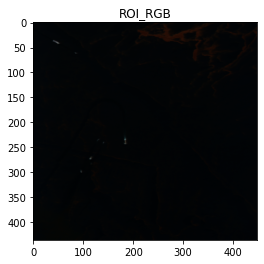

In [17]:
ROI_RGB = ROI[:,:,rgb_bands]
print("ROI_RGB Shape:", ROI_RGB.shape)
  
plt.imshow(ROI_RGB)
plt.title("ROI_RGB")
plt.savefig("./pics/ROI_RGB.png")

<a id="section1.3"></a>
## 1.3.  ROI Ground Truth Visualization - RGB Channels (436 x 449)

### Creating the o/1 label for Orange fixels for oil spill & background pixels

GT_RGB  Shape: (436, 449, 3)


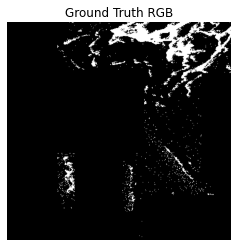

In [3]:
GT_RGB = np.zeros((ROI.shape[0], ROI.shape[1], 3))

for i in range(GT_RGB.shape[0]):
    for j in range(GT_RGB.shape[1]):
        
        # Using all spectral bands
        pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        pixel_dist = [np.sqrt(np.sum(target_spectrums[i,:] - pixel_spectrum)**2)
                for i in range(target_spectrums.shape[0])]
        
        min_dist_target_spectrum = min(pixel_dist)
        
#         print(min_dist_target_spectrum)

        if min_dist_target_spectrum >= 3e-1:
            GT_RGB[i,j,:] = 1    
            
print("GT_RGB  Shape:", GT_RGB.shape)  


for i in range(0,436):
    for j in range(0,101):
        GT_RGB[i,j,:] = 0
        
for i in range(96,262):
    for j in range(0,275):
        GT_RGB[i,j,:] = 0        

for i in range(346,436):
    for j in range(272,449):
        GT_RGB[i,j,:] = 0  

for i in range(256,436):
    for j in range(136,231):
        GT_RGB[i,j,:] = 0 
        
for i in range(380,436):
    for j in range(100,264):
        GT_RGB[i,j,:] = 0 

for i in range(102,321):
    for j in range(390,449):
        GT_RGB[i,j,:] = 0 
        
plt.axis('off')
plt.imshow(GT_RGB)
plt.title("Ground Truth RGB")
plt.savefig("./pics/GT_RGB.png", bbox_inches='tight', transparent=True, pad_inches=0)

<a id="section1.4"></a>
## 1.4.  Background/Target Data - With & Without MNF

### Using k-means clustering to select 100 representative pixels for background & target each

In [29]:
# Using k-means clustering to reduce data sample size
background, target = [], []
background_MNF, target_MNF = [], []

for i in range(GT_RGB.shape[0]):
    for j in range(GT_RGB.shape[1]):
        
        if sum(GT_RGB[i,j,:]) == 0.0:
            background.append(ROI[i, j, :].reshape(-1,1))
            background_MNF.append(ROI_MNF[i, j, :].reshape(-1,1))
        else:
            target.append(ROI[i, j, :].reshape(-1,1))
            target_MNF.append(ROI_MNF[i, j, :].reshape(-1,1))             

            
#### Without MNF ################
print("Starting Without MNF")
background = np.array(background)
background = background.reshape(background.shape[0], background.shape[1])
print("background Pixels Shape:", background.shape)

kmeans_background = KMeans(n_clusters=100, random_state=0).fit(background)
centroids_background = kmeans_background.cluster_centers_
centroids_background = centroids_background.T
print("Background Centroids Shape:", centroids_background.shape)
background = centroids_background


target = np.array(target)
target = target.reshape(target.shape[0], target.shape[1])
print("Target Pixels Shape:", target.shape)

kmeans_target = KMeans(n_clusters=100, random_state=0).fit(target)
centroids_target = kmeans_target.cluster_centers_
print("Target Centroids Shape:", centroids_target.shape)

#######################################

print("-------------")

#### Without MNF ################
print("Starting With MNF")
background_MNF = np.array(background_MNF)
background_MNF = background_MNF.reshape(background_MNF.shape[0], background_MNF.shape[1])
print("background_MNF Pixels Shape:", background_MNF.shape)

kmeans_background_MNF = KMeans(n_clusters=100, random_state=0).fit(background_MNF)
centroids_background_MNF = kmeans_background_MNF.cluster_centers_
centroids_background_MNF = centroids_background_MNF.T
print("Background_MNF Centroids Shape:", centroids_background_MNF.shape)
background_MNF = centroids_background_MNF


target_MNF = np.array(target_MNF)
target_MNF = target_MNF.reshape(target_MNF.shape[0], target_MNF.shape[1])
print("Target_MNF Pixels Shape:", target_MNF.shape)

kmeans_target_MNF = KMeans(n_clusters=100, random_state=0).fit(target_MNF)
centroids_target_MNF = kmeans_target_MNF.cluster_centers_
print("Target_MNF Centroids Shape:", centroids_target_MNF.shape)
#######################################

Starting Without MNF
background Pixels Shape: (184805, 187)
Background Centroids Shape: (187, 100)
Target Pixels Shape: (10959, 187)
Target Centroids Shape: (100, 187)
-------------
Starting With MNF
background_MNF Pixels Shape: (184805, 187)
Background_MNF Centroids Shape: (187, 100)
Target_MNF Pixels Shape: (10959, 187)
Target_MNF Centroids Shape: (100, 187)


In [31]:
with open("./kernel_data/centroids_background_MNF.pkl","wb") as f:
    pkl.dump(centroids_background_MNF, f)
    
with open("./kernel_data/centroids_target_MNF.pkl","wb") as f:
    pkl.dump(centroids_target_MNF, f)
    
with open("./kernel_data/background_MNF.pkl","wb") as f:
    pkl.dump(background_MNF, f)
    
with open("./kernel_data/target_MNF.pkl","wb") as f:
    pkl.dump(target_MNF, f)

<a id="section2.2"></a>
## 2.2.  Helper Functions

In [77]:
d = avg_target_spectrum
d = d.reshape(-1,1)

#Gaussian_Radial Basis Function (GRBF) kernel
# width of Gaussian RBF kernel, to be determined with trial & errors
C = 5
def kernel_GRBF(x, y):                     
    norm= np.linalg.norm(x - y)
    return np.exp(-1*norm*norm/C)


#Polynomial Kernel.
D     = 5 #power parameter of polynomial kernel, tbd
THETA = 1 #constant term for polynomial kernel, tbd

def kernel_poly(x,y, D = 5, THETA = 1):
    x = x.reshape(1,-1)
    y = y.reshape(-1,1)
    val = np.power(np.dot(x,y)+THETA, D)
    val = val[0]
    return val

#Spectral angle_based kernel.
def kernel_spectral(x, y):        
    norm_x= np.linalg.norm(x)
    norm_y= np.linalg.norm(y)
    x = x.reshape(1,-1)
    y = y.reshape(-1,1)    
    dot= np.dot(x,y)
    val = dot/(norm_x*norm_y)
    val = val[0][0]
    return val


def GRAM_MATRIX(samples, kernel="Gaussian RBF"):
    K = np.zeros((samples.shape[1], samples.shape[1]))
    
    for i in range(samples.shape[1]):
        for j in range(samples.shape[1]):
            x = samples[:,i].reshape(-1,1)
            y = samples[:,j].reshape(-1,1)
            if kernel=="Gaussian RBF":
                K[i,j] = kernel_GRBF(x, y)
            elif kernel == "polynomial":
                K[i,j] = kernel_poly(x, y)
            elif kernel == "spectral angle":
                K[i,j] = kernel_spectral(x, y)
                
    return K

def K_X(samples, r, kernel="Gaussian RBF"):
    x = []
    for i in range(samples.shape[1]):
        if kernel == "Gaussian RBF":
            x.append(kernel_GRBF(samples[:,i], r))
        elif kernel == "polynomial":
            x.append(kernel_poly(samples[:,i], r))
        elif kernel == "spectral angle":
            x.append(kernel_spectral(samples[:,i], r))
            
    x = np.array(x).reshape(-1,1)
    return x


def K_Xbdd(background, kernel = "Gaussian RBF"):

    K_X_b = GRAM_MATRIX(background, kernel = kernel)
    eigen_vals, eigen_vecs = np.linalg.eig(K_X_b)
    
    eigen_mat = np.zeros((eigen_vecs.shape[0], eigen_vecs.shape[0]))
    for i in range(eigen_mat.shape[0]):
        eigen_mat[i,i] = 1/np.sqrt(eigen_vals[i])
    Beta = np.matmul(eigen_mat, eigen_vecs)

    # K(X_b, d)
    K_Xb_d = K_X(background, d, kernel=kernel)

    new_samples = np.concatenate([background, d], axis=1)
    K_X_bd = GRAM_MATRIX(new_samples, kernel =kernel)
    eigen_vals, eigen_vecs = np.linalg.eig(K_X_bd)

    eigen_mat = np.zeros((eigen_vecs.shape[0], eigen_vecs.shape[0]))
    for i in range(eigen_mat.shape[0]):
        eigen_mat[i,i] = 1/eigen_vals[i]
    Gamma = np.matmul(eigen_mat, eigen_vecs)

    # K(X_bd, d)
    if kernel == "Gaussian RBF":
        K_dd = np.array(kernel_GRBF(d,d)).reshape(1,1)
    elif kernel == "polynomial":
        K_dd = np.array(kernel_poly(d,d)).reshape(1,1)
    elif kernel == "spectral angle":
        K_dd = np.array(kernel_spectral(d,d)).reshape(1,1) 
    K_Xbd_d = np.concatenate([K_Xb_d, K_dd], axis=0)
    
    return K_Xb_d, K_Xbd_d, Gamma, Beta


def KOSP(K_Xb_d, K_Xbd_d, r, background, Gamma, Beta, kernel="Gaussian RBF"):
    
    # K(X_b, r)
    K_Xb_r = K_X(background, r, kernel=kernel)

    # K(X_bd, d)
    if kernel == "Gaussian RBF":
        K_dr = np.array(kernel_GRBF(d,r)).reshape(1,1)
    elif kernel == "polynomial":
        K_dr = np.array(kernel_poly(d,r)).reshape(1,1)
    elif kernel == "spectral angle":
        K_dr = np.array(kernel_spectral(d,r)).reshape(1,1)
        
    K_Xbd_r = np.concatenate([K_Xb_r, K_dr], axis=0)
    
    # eqn 27
    x = np.matmul(K_Xbd_d.T, Gamma)
    x = np.matmul(x, Gamma.T)
    x = np.matmul(x, K_Xbd_r)
    
    y = np.matmul(K_Xb_d.T, Beta)
    y = np.matmul(y, Beta.T)
    y = np.matmul(y, K_Xb_r)    
    
    d_osp = x - y
    d_osp = d_osp[0][0]

    return d_osp

<a id="section2.3"></a>
## 2.3.  Simple OSP

P_u shape (187, 187)


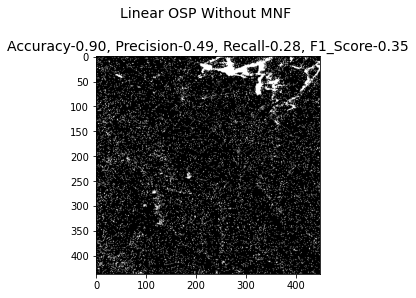

In [89]:
# # Projection rejection operator - eqn 3 (I - U.U^)
U_pinv = np.linalg.pinv(centroids_background)
P_u = np.identity(187) - np.matmul(centroids_background, U_pinv) # I - U.U^#
print("P_u shape", P_u.shape)

THRESHOLD = 3.5e-4

def OSP(x):
    
    # eqn 7
    x = x.reshape(1, -1)
#     print("x shape:{}, x.T shape:{}".format(x.shape, (x.T).shape))
    d_osp = np.matmul(x, P_u)
#     print("d_osp shape", d_osp.shape)
    d_osp = np.matmul(d_osp, x.T)
    
    return d_osp

predictions_OSP = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_OSP = []

PREDS_OSP, GT_LABELS_OSP = [], []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:]

        y = OSP(current_pixel_spectrum)

#         print(y)

        if y >= THRESHOLD:
            predictions_OSP[i,j,:] = 1
        else:
            predictions_OSP[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_OSP.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_OSP.append(0)
        else:
            GT_LABELS_OSP.append(1)

        pred = sum(predictions_OSP[i,j,:])            
        if pred == 0.0:
            PREDS_OSP.append(0)
        else:
            PREDS_OSP.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_OSP.pkl","wb") as f:
    pkl.dump(predictions_OSP, f)
with open("./kernel_data/y_OSP.pkl","wb") as f:
    pkl.dump(y_OSP, f)
with open("./kernel_data/PREDS_OSP.pkl","wb") as f:
    pkl.dump(PREDS_OSP, f)
with open("./kernel_data/GT_LABELS_OSP.pkl","wb") as f:
    pkl.dump(GT_LABELS_OSP, f) 

accuracy = accuracy_score(PREDS_OSP, GT_LABELS_OSP)
precision = precision_score(PREDS_OSP, GT_LABELS_OSP)
recall = recall_score(PREDS_OSP, GT_LABELS_OSP)
f1 = f1_score(PREDS_OSP, GT_LABELS_OSP)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_OSP)
plt.title("Linear OSP Without MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/OSP.png")

<a id="section2.4"></a>
## 2.4.  KOSP (Gaussian RBF Kernel)

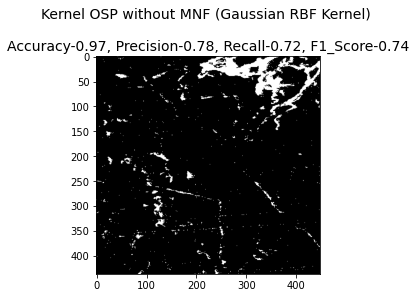

In [9]:
# THRESHOLD = 1.12e14
THRESHOLD = 2e13

K_Xb_d, K_Xbd_d, Gamma, Beta = K_Xbdd(centroids_background, kernel = "Gaussian RBF")


predictions_KOSP_GRBF = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_KOSP_GRBF = []

PREDS_KOSP_GRBF, GT_LABELS_KOSP_GRBF = [], []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:]

        y = KOSP(K_Xb_d, K_Xbd_d, current_pixel_spectrum, centroids_background, Gamma, Beta, kernel = "Gaussian RBF")

#         print(y)

        if y <= THRESHOLD:
            predictions_KOSP_GRBF[i,j,:] = 1
        else:
            predictions_KOSP_GRBF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KOSP_GRBF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KOSP_GRBF.append(0)
        else:
            GT_LABELS_KOSP_GRBF.append(1)

        pred = sum(predictions_KOSP_GRBF[i,j,:])            
        if pred == 0.0:
            PREDS_KOSP_GRBF.append(0)
        else:
            PREDS_KOSP_GRBF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KOSP_GRBF.pkl","wb") as f:
    pkl.dump(predictions_KOSP_GRBF, f)
with open("./kernel_data/y_KOSP_GRBF.pkl","wb") as f:
    pkl.dump(y_KOSP_GRBF, f)
with open("./kernel_data/PREDS_KOSP_GRBF.pkl","wb") as f:
    pkl.dump(PREDS_KOSP_GRBF, f)
with open("./kernel_data/GT_LABELS_KOSP_GRBF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KOSP_GRBF, f) 
    
accuracy = accuracy_score(PREDS_KOSP_GRBF, GT_LABELS_KOSP_GRBF)
precision = precision_score(PREDS_KOSP_GRBF, GT_LABELS_KOSP_GRBF)
recall = recall_score(PREDS_KOSP_GRBF, GT_LABELS_KOSP_GRBF)
f1 = f1_score(PREDS_KOSP_GRBF, GT_LABELS_KOSP_GRBF)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KOSP_GRBF)
plt.title("Kernel OSP without MNF (Gaussian RBF Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KOSP_GRBF.png")

<a id="section2.5"></a>
## 2.5.  KOSP (Polynomial Kernel)

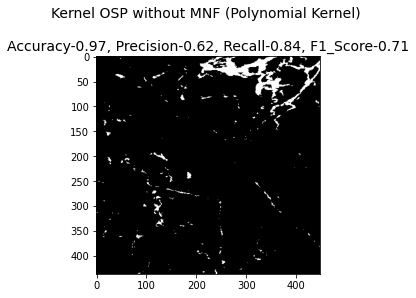

In [13]:
# THRESHOLD = 8e11
THRESHOLD = 8e14

K_Xb_d, K_Xbd_d, Gamma, Beta = K_Xbdd(centroids_background, kernel = "polynomial")


predictions_KOSP_Polynomial = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_KOSP_Polynomial = []

PREDS_KOSP_Polynomial, GT_LABELS_KOSP_Polynomial = [], []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:]

        y = KOSP(K_Xb_d, K_Xbd_d, current_pixel_spectrum, centroids_background, Gamma, Beta, kernel = "polynomial")

#         print(y)

        if y >= THRESHOLD:
            predictions_KOSP_Polynomial[i,j,:] = 1
        else:
            predictions_KOSP_Polynomial[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KOSP_Polynomial.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KOSP_Polynomial.append(0)
        else:
            GT_LABELS_KOSP_Polynomial.append(1)

        pred = sum(predictions_KOSP_Polynomial[i,j,:])            
        if pred == 0.0:
            PREDS_KOSP_Polynomial.append(0)
        else:
            PREDS_KOSP_Polynomial.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KOSP_Polynomial.pkl","wb") as f:
    pkl.dump(predictions_KOSP_Polynomial, f)
with open("./kernel_data/y_KOSP_Polynomial.pkl","wb") as f:
    pkl.dump(y_KOSP_Polynomial, f)
with open("./kernel_data/PREDS_KOSP_Polynomial.pkl","wb") as f:
    pkl.dump(PREDS_KOSP_Polynomial, f)
with open("./kernel_data/GT_LABELS_KOSP_Polynomial.pkl","wb") as f:
    pkl.dump(GT_LABELS_KOSP_Polynomial, f)             
            
accuracy = accuracy_score(PREDS_KOSP_Polynomial, GT_LABELS_KOSP_Polynomial)
precision = precision_score(PREDS_KOSP_Polynomial, GT_LABELS_KOSP_Polynomial)
recall = recall_score(PREDS_KOSP_Polynomial, GT_LABELS_KOSP_Polynomial)
f1 = f1_score(PREDS_KOSP_Polynomial, GT_LABELS_KOSP_Polynomial)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KOSP_Polynomial)
plt.title("Kernel OSP without MNF (Polynomial Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KOSP_Polynomial.png")

<a id="section2.6"></a>
## 2.6.  KOSP (Spectral Angle Kernel)

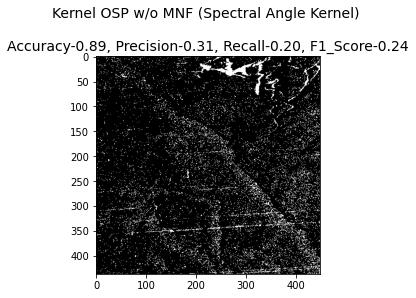

In [7]:
# THRESHOLD = 5e13
THRESHOLD = 5.9e13

K_Xb_d, K_Xbd_d, Gamma, Beta = K_Xbdd(centroids_background, kernel = "spectral angle")


predictions_KOSP_SpectralAngle = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_KOSP_SpectralAngle = []

PREDS_KOSP_SpectralAngle, GT_LABELS_KOSP_SpectralAngle = [], []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:]

        y = KOSP(K_Xb_d, K_Xbd_d, current_pixel_spectrum, centroids_background, Gamma, Beta, kernel = "spectral angle")

#         print(y)

        if y <= THRESHOLD:
            predictions_KOSP_SpectralAngle[i,j,:] = 1
        else:
            predictions_KOSP_SpectralAngle[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KOSP_SpectralAngle.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KOSP_SpectralAngle.append(0)
        else:
            GT_LABELS_KOSP_SpectralAngle.append(1)

        pred = sum(predictions_KOSP_SpectralAngle[i,j,:])            
        if pred == 0.0:
            PREDS_KOSP_SpectralAngle.append(0)
        else:
            PREDS_KOSP_SpectralAngle.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KOSP_SpectralAngle.pkl","wb") as f:
    pkl.dump(predictions_KOSP_SpectralAngle, f)
with open("./kernel_data/y_KOSP_SpectralAngle.pkl","wb") as f:
    pkl.dump(y_KOSP_SpectralAngle, f)
with open("./kernel_data/PREDS_KOSP_SpectralAngle.pkl","wb") as f:
    pkl.dump(PREDS_KOSP_SpectralAngle, f)
with open("./kernel_data/GT_LABELS_KOSP_SpectralAngle.pkl","wb") as f:
    pkl.dump(GT_LABELS_KOSP_SpectralAngle, f) 
    
accuracy = accuracy_score(PREDS_KOSP_SpectralAngle, GT_LABELS_KOSP_SpectralAngle)
precision = precision_score(PREDS_KOSP_SpectralAngle, GT_LABELS_KOSP_SpectralAngle)
recall = recall_score(PREDS_KOSP_SpectralAngle, GT_LABELS_KOSP_SpectralAngle)
f1 = f1_score(PREDS_KOSP_SpectralAngle, GT_LABELS_KOSP_SpectralAngle)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KOSP_SpectralAngle)
plt.title("Kernel OSP w/o MNF (Spectral Angle Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KOSP_SpectralAngle.png")

<a id="section3"></a>
## 3.  Performance on Data With MNF

<a id="section3.1"></a>
## 3.1.  Helper Functions

### Mostly same as sec 2.1 (Helper Functions) except some changes in constants C, D, THETA if needed

In [91]:
d = avg_target_spectrum_MNF
d = d.reshape(-1,1)

#Gaussian_Radial Basis Function (GRBF) kernel
# width of Gaussian RBF kernel, to be determined with trial & errors
# C = 1e15
C = 1e5
def kernel_GRBF(x, y, C=1e5):                     
    norm= np.linalg.norm(x - y)
#     print("**")
#     print(norm)
    val = np.exp(-1*norm*norm/C)
#     print(val)
#     print("---")
    return val


#Polynomial Kernel.
D     = 3 #power parameter of polynomial kernel, tbd
THETA = 1 #constant term for polynomial kernel, tbd

def kernel_poly(x,y, D = 3, THETA = 1):
    x = x.reshape(1,-1)
    y = y.reshape(-1,1)
    val = np.power(np.dot(x,y)+THETA, D)
    val = val[0]
    return val

#Spectral angle_based kernel.
def kernel_spectral(x, y):        
    norm_x= np.linalg.norm(x)
    norm_y= np.linalg.norm(y)
    x = x.reshape(1,-1)
    y = y.reshape(-1,1)    
    dot= np.dot(x,y)
    val = dot/(norm_x*norm_y)
    val = val[0][0]
    return val


def GRAM_MATRIX(samples, kernel="Gaussian RBF"):
    K = np.zeros((samples.shape[1], samples.shape[1]))
    
    for i in range(samples.shape[1]):
        for j in range(samples.shape[1]):
            x = samples[:,i].reshape(-1,1)
            y = samples[:,j].reshape(-1,1)
            if kernel=="Gaussian RBF":
                K[i,j] = kernel_GRBF(x, y)
            elif kernel == "polynomial":
                K[i,j] = kernel_poly(x, y)
            elif kernel == "spectral angle":
                K[i,j] = kernel_spectral(x, y)
                
    return K

def K_X(samples, r, kernel="Gaussian RBF"):
    x = []
    for i in range(samples.shape[1]):
        if kernel == "Gaussian RBF":
            x.append(kernel_GRBF(samples[:,i], r))
        elif kernel == "polynomial":
            x.append(kernel_poly(samples[:,i], r))
        elif kernel == "spectral angle":
            x.append(kernel_spectral(samples[:,i], r))
            
    x = np.array(x).reshape(-1,1)
    return x


def K_Xbdd(background, kernel = "Gaussian RBF"):

    K_X_b = GRAM_MATRIX(background, kernel = kernel)
    eigen_vals, eigen_vecs = np.linalg.eig(K_X_b)
    
    eigen_mat = np.zeros((eigen_vecs.shape[0], eigen_vecs.shape[0]))
    for i in range(eigen_mat.shape[0]):
        eigen_mat[i,i] = 1/np.sqrt(eigen_vals[i])
    Beta = np.matmul(eigen_mat, eigen_vecs)

    # K(X_b, d)
    K_Xb_d = K_X(background, d, kernel=kernel)

    new_samples = np.concatenate([background, d], axis=1)
    K_X_bd = GRAM_MATRIX(new_samples, kernel =kernel)
    eigen_vals, eigen_vecs = np.linalg.eig(K_X_bd)

    eigen_mat = np.zeros((eigen_vecs.shape[0], eigen_vecs.shape[0]))
    for i in range(eigen_mat.shape[0]):
        eigen_mat[i,i] = 1/eigen_vals[i]
    Gamma = np.matmul(eigen_mat, eigen_vecs)

    # K(X_bd, d)
    if kernel == "Gaussian RBF":
        K_dd = np.array(kernel_GRBF(d,d)).reshape(1,1)
    elif kernel == "polynomial":
        K_dd = np.array(kernel_poly(d,d)).reshape(1,1)
    elif kernel == "spectral angle":
        K_dd = np.array(kernel_spectral(d,d)).reshape(1,1) 
    K_Xbd_d = np.concatenate([K_Xb_d, K_dd], axis=0)
    
    return K_Xb_d, K_Xbd_d, Gamma, Beta


def KOSP(K_Xb_d, K_Xbd_d, r, background, Gamma, Beta, kernel="Gaussian RBF"):
    
    # K(X_b, r)
    K_Xb_r = K_X(background, r, kernel=kernel)

    # K(X_bd, d)
    if kernel == "Gaussian RBF":
        K_dr = np.array(kernel_GRBF(d,r)).reshape(1,1)
    elif kernel == "polynomial":
        K_dr = np.array(kernel_poly(d,r)).reshape(1,1)
    elif kernel == "spectral angle":
        K_dr = np.array(kernel_spectral(d,r)).reshape(1,1)
        
    K_Xbd_r = np.concatenate([K_Xb_r, K_dr], axis=0)
    
    # eqn 27
    x = np.matmul(K_Xbd_d.T, Gamma)
    x = np.matmul(x, Gamma.T)
    x = np.matmul(x, K_Xbd_r)
    
    y = np.matmul(K_Xb_d.T, Beta)
    y = np.matmul(y, Beta.T)
    y = np.matmul(y, K_Xb_r)    
    
    d_osp = x - y
    d_osp = d_osp[0][0]

    return d_osp

<a id="section3.2"></a>
## 3.2.  MNF + Linear OSP

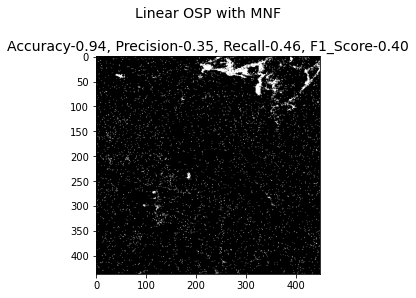

In [92]:
# # Projection rejection operator - eqn 3 (I - U.U^)
U_pinv = np.linalg.pinv(centroids_background_MNF)
P_u = np.identity(187) - np.matmul(centroids_background_MNF, U_pinv) # I - U.U^#

THRESHOLD = 105

def OSP(x):
    
    # eqn 7
    x = x.reshape(1,-1)
    d_OSP_MNF = np.matmul(x, P_u)
    d_OSP_MNF = np.matmul(d_OSP_MNF, x.T)
    
    return d_OSP_MNF

predictions_OSP_MNF = np.zeros((ROI_MNF.shape[0],ROI_MNF.shape[1],3))
y_OSP_MNF = []

PREDS_OSP_MNF, GT_LABELS_OSP_MNF = [], []

for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i,j,:]

        y = OSP(current_pixel_spectrum)

#         print(y)

        if y >= THRESHOLD:
            predictions_OSP_MNF[i,j,:] = 1
        else:
            predictions_OSP_MNF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_OSP_MNF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_OSP_MNF.append(0)
        else:
            GT_LABELS_OSP_MNF.append(1)

        pred = sum(predictions_OSP_MNF[i,j,:])            
        if pred == 0.0:
            PREDS_OSP_MNF.append(0)
        else:
            PREDS_OSP_MNF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_OSP_MNF.pkl","wb") as f:
    pkl.dump(predictions_OSP_MNF, f)
with open("./kernel_data/y_OSP_MNF.pkl","wb") as f:
    pkl.dump(y_OSP_MNF, f)
with open("./kernel_data/PREDS_OSP_MNF.pkl","wb") as f:
    pkl.dump(PREDS_OSP_MNF, f)
with open("./kernel_data/GT_LABELS_OSP_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_OSP_MNF, f) 
    
    
accuracy = accuracy_score(PREDS_OSP_MNF, GT_LABELS_OSP_MNF)
precision = precision_score(PREDS_OSP_MNF, GT_LABELS_OSP_MNF)
recall = recall_score(PREDS_OSP_MNF, GT_LABELS_OSP_MNF)
f1 = f1_score(PREDS_OSP_MNF, GT_LABELS_OSP_MNF)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_OSP_MNF)
plt.title("Linear OSP with MNF\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/OSP_MNF.png")

<a id="section3.3"></a>
## 3.3.  MNF + KOSP (Gaussian RBF Kernel)

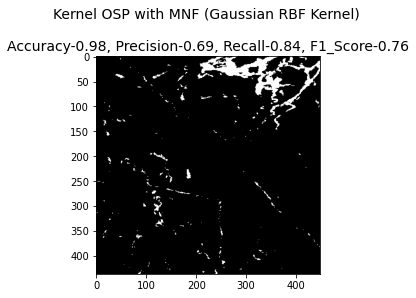

In [64]:
# THRESHOLD = 5.5
THRESHOLD = 4.5

K_Xb_d, K_Xbd_d, Gamma, Beta = K_Xbdd(centroids_background_MNF, kernel = "Gaussian RBF")


predictions_KOSP_GRBF_MNF = np.zeros((ROI_MNF.shape[0],ROI_MNF.shape[1],3))
y_KOSP_GRBF_MNF = []

PREDS_KOSP_GRBF_MNF, GT_LABELS_KOSP_GRBF_MNF = [], []

for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i,j,:]

        y = KOSP(K_Xb_d, K_Xbd_d, current_pixel_spectrum, centroids_background_MNF, Gamma, Beta, kernel = "Gaussian RBF")

#         print(y)

        if y <= THRESHOLD:        
            predictions_KOSP_GRBF_MNF[i,j,:] = 1
        else:
            predictions_KOSP_GRBF_MNF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KOSP_GRBF_MNF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KOSP_GRBF_MNF.append(0)
        else:
            GT_LABELS_KOSP_GRBF_MNF.append(1)

        pred = sum(predictions_KOSP_GRBF_MNF[i,j,:])            
        if pred == 0.0:
            PREDS_KOSP_GRBF_MNF.append(0)
        else:
            PREDS_KOSP_GRBF_MNF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KOSP_GRBF_MNF.pkl","wb") as f:
    pkl.dump(predictions_KOSP_GRBF_MNF, f)
with open("./kernel_data/y_KOSP_GRBF_MNF.pkl","wb") as f:
    pkl.dump(y_KOSP_GRBF_MNF, f)
with open("./kernel_data/PREDS_KOSP_GRBF_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KOSP_GRBF_MNF, f)
with open("./kernel_data/GT_LABELS_KOSP_GRBF_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KOSP_GRBF_MNF, f) 
    
accuracy = accuracy_score(PREDS_KOSP_GRBF_MNF, GT_LABELS_KOSP_GRBF_MNF)
precision = precision_score(PREDS_KOSP_GRBF_MNF, GT_LABELS_KOSP_GRBF_MNF)
recall = recall_score(PREDS_KOSP_GRBF_MNF, GT_LABELS_KOSP_GRBF_MNF)
f1 = f1_score(PREDS_KOSP_GRBF_MNF, GT_LABELS_KOSP_GRBF_MNF)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KOSP_GRBF_MNF)
plt.title("Kernel OSP with MNF (Gaussian RBF Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KOSP_GRBF_MNF.png")

<a id="section3.4"></a>
## 3.4.  MNF + KOSP (Polynomial Kernel)

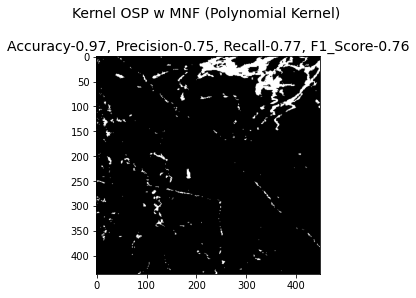

In [61]:
THRESHOLD = 1e22

K_Xb_d, K_Xbd_d, Gamma, Beta = K_Xbdd(centroids_background_MNF, kernel = "polynomial")


predictions_KOSP_Polynomial_MNF = np.zeros((ROI_MNF.shape[0],ROI_MNF.shape[1],3))
y_KOSP_Polynomial_MNF = []

PREDS_KOSP_Polynomial_MNF, GT_LABELS_KOSP_Polynomial_MNF = [], []

for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i,j,:]

        y = KOSP(K_Xb_d, K_Xbd_d, current_pixel_spectrum, centroids_background_MNF, Gamma, Beta, kernel = "polynomial")

#         print(y)

        if y >= THRESHOLD:
            predictions_KOSP_Polynomial_MNF[i,j,:] = 1
        else:
            predictions_KOSP_Polynomial_MNF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KOSP_Polynomial_MNF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KOSP_Polynomial_MNF.append(0)
        else:
            GT_LABELS_KOSP_Polynomial_MNF.append(1)

        pred = sum(predictions_KOSP_Polynomial_MNF[i,j,:])            
        if pred == 0.0:
            PREDS_KOSP_Polynomial_MNF.append(0)
        else:
            PREDS_KOSP_Polynomial_MNF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KOSP_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(predictions_KOSP_Polynomial_MNF, f)
with open("./kernel_data/y_KOSP_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(y_KOSP_Polynomial_MNF, f)
with open("./kernel_data/PREDS_KOSP_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KOSP_Polynomial_MNF, f)
with open("./kernel_data/GT_LABELS_KOSP_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KOSP_Polynomial_MNF, f)             
            
accuracy = accuracy_score(PREDS_KOSP_Polynomial_MNF, GT_LABELS_KOSP_Polynomial_MNF)
precision = precision_score(PREDS_KOSP_Polynomial_MNF, GT_LABELS_KOSP_Polynomial_MNF)
recall = recall_score(PREDS_KOSP_Polynomial_MNF, GT_LABELS_KOSP_Polynomial_MNF)
f1 = f1_score(PREDS_KOSP_Polynomial_MNF, GT_LABELS_KOSP_Polynomial_MNF)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KOSP_Polynomial_MNF)
plt.title("Kernel OSP w MNF (Polynomial Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KOSP_Polynomial_MNF.png")

<a id="section4.4"></a>
## 4.4. MNF + KOSP (Spectral Angle Kernel)

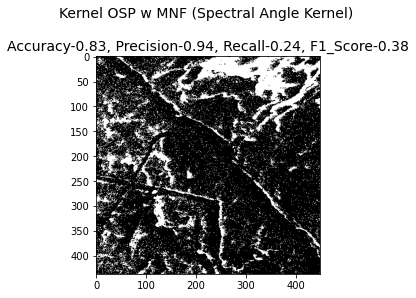

In [65]:
THRESHOLD = -5e11

K_Xb_d, K_Xbd_d, Gamma, Beta = K_Xbdd(centroids_background_MNF, kernel = "spectral angle")


predictions_KOSP_SpectralAngle_MNF = np.zeros((ROI_MNF.shape[0],ROI_MNF.shape[1],3))
y_KOSP_SpectralAngle_MNF = []

PREDS_KOSP_SpectralAngle_MNF, GT_LABELS_KOSP_SpectralAngle_MNF = [], []

for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i,j,:]

        y = KOSP(K_Xb_d, K_Xbd_d, current_pixel_spectrum, centroids_background_MNF, Gamma, Beta, kernel = "spectral angle")

#         print(y)

#         if y >= THRESHOLD:
        if y <= THRESHOLD:
            predictions_KOSP_SpectralAngle_MNF[i,j,:] = 1
        else:
            predictions_KOSP_SpectralAngle_MNF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KOSP_SpectralAngle_MNF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KOSP_SpectralAngle_MNF.append(0)
        else:
            GT_LABELS_KOSP_SpectralAngle_MNF.append(1)

        pred = sum(predictions_KOSP_SpectralAngle_MNF[i,j,:])            
        if pred == 0.0:
            PREDS_KOSP_SpectralAngle_MNF.append(0)
        else:
            PREDS_KOSP_SpectralAngle_MNF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KOSP_SpectralAngle_MNF.pkl","wb") as f:
    pkl.dump(predictions_KOSP_SpectralAngle_MNF, f)
with open("./kernel_data/y_KOSP_SpectralAngle_MNF.pkl","wb") as f:
    pkl.dump(y_KOSP_SpectralAngle_MNF, f)
with open("./kernel_data/PREDS_KOSP_SpectralAngle_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KOSP_SpectralAngle_MNF, f)
with open("./kernel_data/GT_LABELS_KOSP_SpectralAngle_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KOSP_SpectralAngle_MNF, f) 
    
accuracy = accuracy_score(PREDS_KOSP_SpectralAngle_MNF, GT_LABELS_KOSP_SpectralAngle_MNF)
precision = precision_score(PREDS_KOSP_SpectralAngle_MNF, GT_LABELS_KOSP_SpectralAngle_MNF)
recall = recall_score(PREDS_KOSP_SpectralAngle_MNF, GT_LABELS_KOSP_SpectralAngle_MNF)
f1 = f1_score(PREDS_KOSP_SpectralAngle_MNF, GT_LABELS_KOSP_SpectralAngle_MNF)


# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KOSP_SpectralAngle_MNF)
plt.title("Kernel OSP w MNF (Spectral Angle Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KOSP_SpectralAngle_MNF.png")

<a id="section4"></a>
## 4. Combined Plots - Results

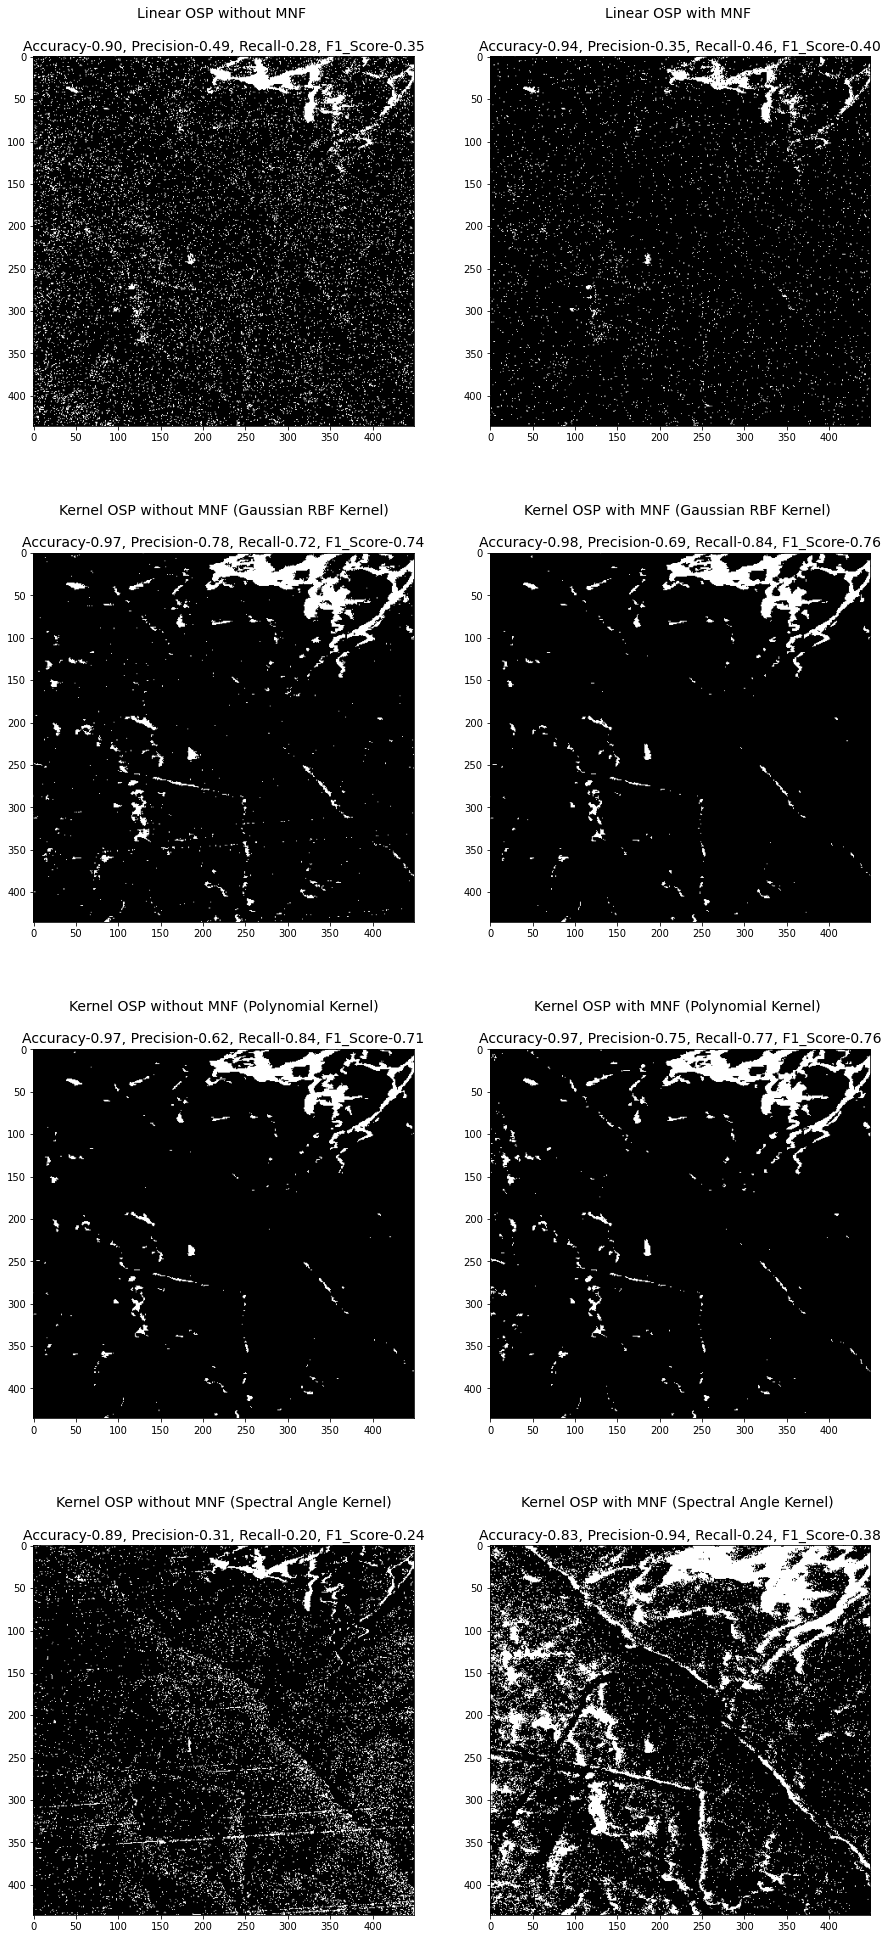

In [103]:
# plt.figure(figsize=(20,15))

plt.figure(figsize=(15,35))

###################################### Linear OSP ###########################################################
plt.subplot(421)
with open("./kernel_data/predictions_OSP.pkl","rb") as f:
    predictions_OSP = pkl.load(f)
with open("./kernel_data/PREDS_OSP.pkl","rb") as f:
    PREDS_OSP = pkl.load(f)
with open("./kernel_data/GT_LABELS_OSP.pkl","rb") as f:
    GT_LABELS_OSP = pkl.load(f)
    
accuracy = accuracy_score(PREDS_OSP, GT_LABELS_OSP)
precision = precision_score(PREDS_OSP, GT_LABELS_OSP)
recall = recall_score(PREDS_OSP, GT_LABELS_OSP)
f1 = f1_score(PREDS_OSP, GT_LABELS_OSP)

plt.imshow(predictions_OSP)
plt.title("Linear OSP without MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(422)
with open("./kernel_data/predictions_OSP_MNF.pkl","rb") as f:
    predictions_OSP_MNF = pkl.load(f)
with open("./kernel_data/PREDS_OSP_MNF.pkl","rb") as f:
    PREDS_OSP_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_OSP_MNF.pkl","rb") as f:
    GT_LABELS_OSP_MNF = pkl.load(f)

accuracy = accuracy_score(PREDS_OSP_MNF, GT_LABELS_OSP_MNF)
precision = precision_score(PREDS_OSP_MNF, GT_LABELS_OSP_MNF)
recall = recall_score(PREDS_OSP_MNF, GT_LABELS_OSP_MNF)
f1 = f1_score(PREDS_OSP_MNF, GT_LABELS_OSP_MNF)

plt.imshow(predictions_OSP_MNF)
plt.title("Linear OSP with MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################
    
###################################### Gaussian RBF Kernel ###########################################################
plt.subplot(423)
with open("./kernel_data/predictions_KOSP_GRBF.pkl","rb") as f:
    predictions_KOSP_GRBF = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_GRBF.pkl","rb") as f:
    PREDS_KOSP_GRBF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_GRBF.pkl","rb") as f:
    GT_LABELS_KOSP_GRBF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KOSP_GRBF, GT_LABELS_KOSP_GRBF)
precision = precision_score(PREDS_KOSP_GRBF, GT_LABELS_KOSP_GRBF)
recall = recall_score(PREDS_KOSP_GRBF, GT_LABELS_KOSP_GRBF)
f1 = f1_score(PREDS_KOSP_GRBF, GT_LABELS_KOSP_GRBF)

plt.imshow(predictions_KOSP_GRBF)
plt.title("\nKernel OSP without MNF (Gaussian RBF Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(424)
with open("./kernel_data/predictions_KOSP_GRBF_MNF.pkl","rb") as f:
    predictions_KOSP_GRBF_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_GRBF_MNF.pkl","rb") as f:
    PREDS_KOSP_GRBF_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_GRBF_MNF.pkl","rb") as f:
    GT_LABELS_KOSP_GRBF_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KOSP_GRBF_MNF, GT_LABELS_KOSP_GRBF_MNF)
precision = precision_score(PREDS_KOSP_GRBF_MNF, GT_LABELS_KOSP_GRBF_MNF)
recall = recall_score(PREDS_KOSP_GRBF_MNF, GT_LABELS_KOSP_GRBF_MNF)
f1 = f1_score(PREDS_KOSP_GRBF_MNF, GT_LABELS_KOSP_GRBF_MNF)

plt.imshow(predictions_KOSP_GRBF_MNF)
plt.title("\nKernel OSP with MNF (Gaussian RBF Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################

###################################### Polynomial Kernel ###########################################################
plt.subplot(425)
with open("./kernel_data/predictions_KOSP_Polynomial.pkl","rb") as f:
    predictions_KOSP_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_Polynomial.pkl","rb") as f:
    PREDS_KOSP_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_Polynomial.pkl","rb") as f:
    GT_LABELS_KOSP_Polynomial = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KOSP_Polynomial, GT_LABELS_KOSP_Polynomial)
precision = precision_score(PREDS_KOSP_Polynomial, GT_LABELS_KOSP_Polynomial)
recall = recall_score(PREDS_KOSP_Polynomial, GT_LABELS_KOSP_Polynomial)
f1 = f1_score(PREDS_KOSP_Polynomial, GT_LABELS_KOSP_Polynomial)

plt.imshow(predictions_KOSP_Polynomial)
plt.title("\nKernel OSP without MNF (Polynomial Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(426)
with open("./kernel_data/predictions_KOSP_Polynomial_MNF.pkl","rb") as f:
    predictions_KOSP_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_Polynomial_MNF.pkl","rb") as f:
    PREDS_KOSP_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KOSP_Polynomial_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KOSP_Polynomial_MNF, GT_LABELS_KOSP_Polynomial_MNF)
precision = precision_score(PREDS_KOSP_Polynomial_MNF, GT_LABELS_KOSP_Polynomial_MNF)
recall = recall_score(PREDS_KOSP_Polynomial_MNF, GT_LABELS_KOSP_Polynomial_MNF)
f1 = f1_score(PREDS_KOSP_Polynomial_MNF, GT_LABELS_KOSP_Polynomial_MNF)

plt.imshow(predictions_KOSP_Polynomial_MNF)
plt.title("\nKernel OSP with MNF (Polynomial Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################


###################################### Spectral Angle Kernel ###########################################################
plt.subplot(427)
with open("./kernel_data/predictions_KOSP_SpectralAngle.pkl","rb") as f:
    predictions_KOSP_SpectralAngle = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_SpectralAngle.pkl","rb") as f:
    PREDS_KOSP_SpectralAngle = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_SpectralAngle.pkl","rb") as f:
    GT_LABELS_KOSP_SpectralAngle = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KOSP_SpectralAngle, GT_LABELS_KOSP_SpectralAngle)
precision = precision_score(PREDS_KOSP_SpectralAngle, GT_LABELS_KOSP_SpectralAngle)
recall = recall_score(PREDS_KOSP_SpectralAngle, GT_LABELS_KOSP_SpectralAngle)
f1 = f1_score(PREDS_KOSP_SpectralAngle, GT_LABELS_KOSP_SpectralAngle)

plt.imshow(predictions_KOSP_SpectralAngle)
plt.title("\nKernel OSP without MNF (Spectral Angle Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(428)
with open("./kernel_data/predictions_KOSP_SpectralAngle_MNF.pkl","rb") as f:
    predictions_KOSP_SpectralAngle_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_SpectralAngle_MNF.pkl","rb") as f:
    PREDS_KOSP_SpectralAngle_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_SpectralAngle_MNF.pkl","rb") as f:
    GT_LABELS_KOSP_SpectralAngle_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KOSP_SpectralAngle_MNF, GT_LABELS_KOSP_SpectralAngle_MNF)
precision = precision_score(PREDS_KOSP_SpectralAngle_MNF, GT_LABELS_KOSP_SpectralAngle_MNF)
recall = recall_score(PREDS_KOSP_SpectralAngle_MNF, GT_LABELS_KOSP_SpectralAngle_MNF)
f1 = f1_score(PREDS_KOSP_SpectralAngle_MNF, GT_LABELS_KOSP_SpectralAngle_MNF)

plt.imshow(predictions_KOSP_SpectralAngle_MNF)
plt.title("\nKernel OSP with MNF (Spectral Angle Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################

plt.savefig("./pics/OSP_KOSP_Combined_Results.png", bbox_inches='tight', pad_inches=.5)

<a id="section6"></a>
## 6.  ROC Curve

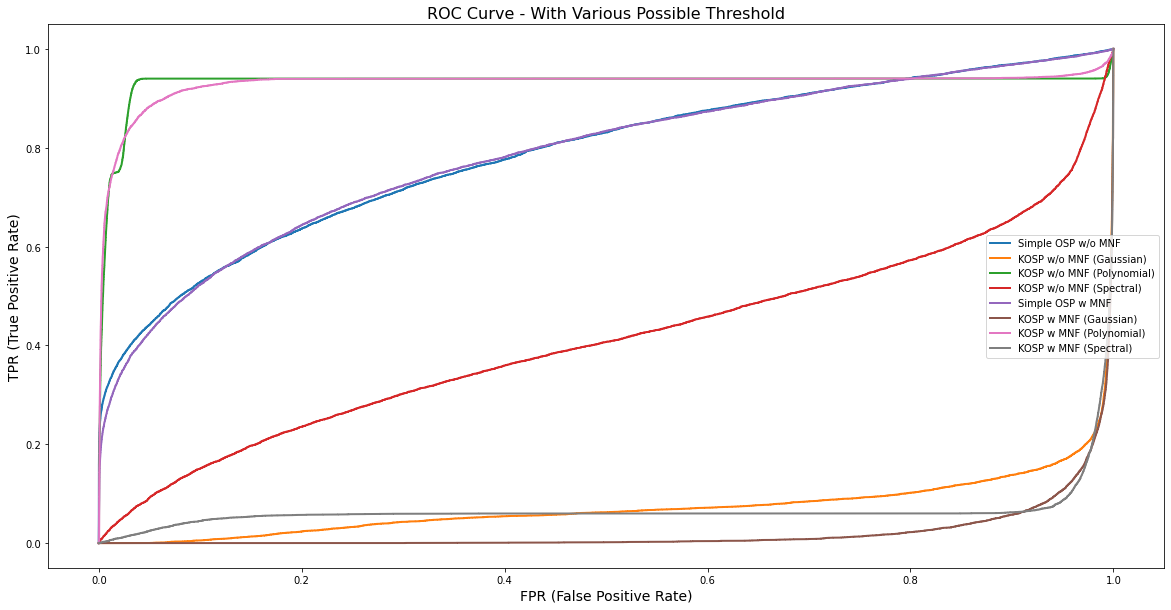

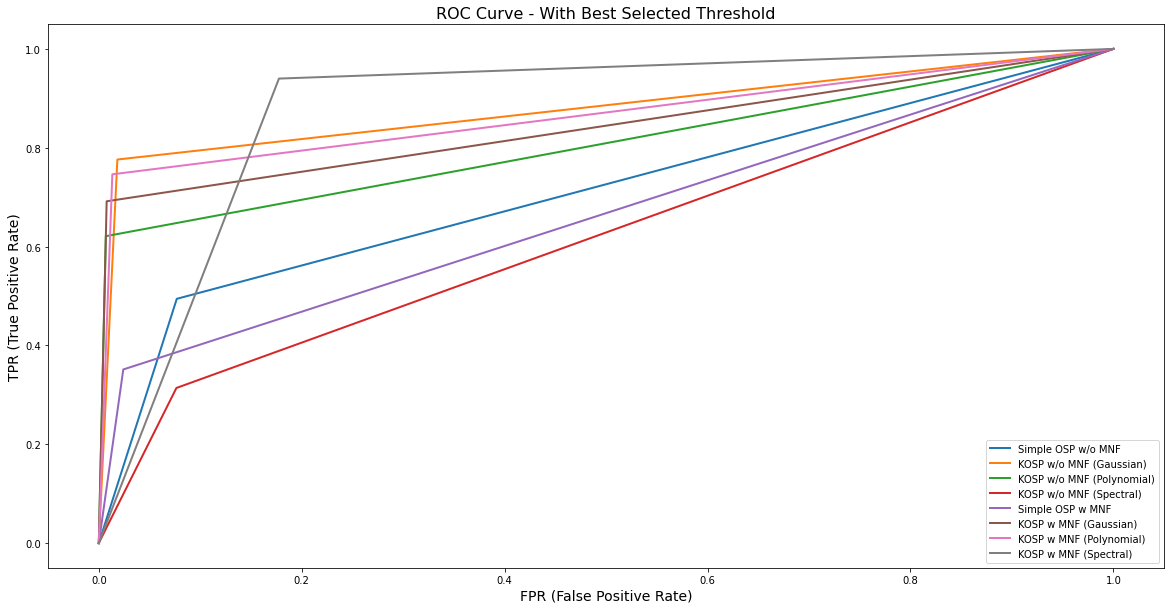

In [100]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)

# reload all pickle files for plotting 

with open("./kernel_data/y_OSP.pkl","rb") as f:
    y_OSP = pkl.load(f)
with open("./kernel_data/PREDS_OSP.pkl","rb") as f:
    PREDS_OSP = pkl.load(f)
with open("./kernel_data/GT_LABELS_OSP.pkl","rb") as f:
    GT_LABELS_OSP = pkl.load(f)
    
    
with open("./kernel_data/y_KOSP_GRBF.pkl","rb") as f:
    y_KOSP_GRBF = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_GRBF.pkl","rb") as f:
    PREDS_KOSP_GRBF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_GRBF.pkl","rb") as f:
    GT_LABELS_KOSP_GRBF = pkl.load(f)
    

with open("./kernel_data/y_KOSP_Polynomial.pkl","rb") as f:
    y_KOSP_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_Polynomial.pkl","rb") as f:
    PREDS_KOSP_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_Polynomial.pkl","rb") as f:
    GT_LABELS_KOSP_Polynomial = pkl.load(f)
    
    
with open("./kernel_data/y_KOSP_SpectralAngle.pkl","rb") as f:
    y_KOSP_SpectralAngle = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_SpectralAngle.pkl","rb") as f:
    PREDS_KOSP_SpectralAngle = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_SpectralAngle.pkl","rb") as f:
    GT_LABELS_KOSP_SpectralAngle = pkl.load(f)
    

    
with open("./kernel_data/y_OSP_MNF.pkl","rb") as f:
    y_OSP_MNF = pkl.load(f)
with open("./kernel_data/PREDS_OSP_MNF.pkl","rb") as f:
    PREDS_OSP_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_OSP_MNF.pkl","rb") as f:
    GT_LABELS_OSP_MNF = pkl.load(f)
    
    
with open("./kernel_data/y_KOSP_GRBF_MNF.pkl","rb") as f:
    y_KOSP_GRBF_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_GRBF_MNF.pkl","rb") as f:
    PREDS_KOSP_GRBF_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_GRBF_MNF.pkl","rb") as f:
    GT_LABELS_KOSP_GRBF_MNF = pkl.load(f)
    

with open("./kernel_data/y_KOSP_Polynomial_MNF.pkl","rb") as f:
    y_KOSP_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_Polynomial_MNF.pkl","rb") as f:
    PREDS_KOSP_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KOSP_Polynomial_MNF = pkl.load(f)
    
    
with open("./kernel_data/y_KOSP_SpectralAngle_MNF.pkl","rb") as f:
    y_KOSP_SpectralAngle_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KOSP_SpectralAngle_MNF.pkl","rb") as f:
    PREDS_KOSP_SpectralAngle_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KOSP_SpectralAngle_MNF.pkl","rb") as f:
    GT_LABELS_KOSP_SpectralAngle_MNF = pkl.load(f)

############################ Plot 1 - ROC Curve with Various Possible Thresholds #################################    
plt.figure(figsize=(20,10))

# using sklearn's roc_curve method to get FPR, TPR & Thresholds for each

# just a minot hack for y_OSP_MNF here as it was throwing some weird error with list type
GT_LABELS_OSP, y_OSP = np.array(GT_LABELS_OSP).reshape(-1,1), np.array(y_OSP).reshape(-1,1)
GT_LABELS_OSP_MNF, y_OSP_MNF = np.array(GT_LABELS_OSP_MNF).reshape(-1,1), np.array(y_OSP_MNF).reshape(-1,1)

fpr_OSP, tpr_OSP, _                              = roc_curve(GT_LABELS_OSP, y_OSP)
fpr_KOSP_GRBF, tpr_KOSP_GRBF, _                  = roc_curve(GT_LABELS_KOSP_GRBF, y_KOSP_GRBF)
fpr_KOSP_Polynomial, tpr_KOSP_Polynomial, _      = roc_curve(GT_LABELS_KOSP_Polynomial, y_KOSP_Polynomial)
fpr_KOSP_SpectralAngle, tpr_KOSP_SpectralAngle,_ = roc_curve(GT_LABELS_KOSP_SpectralAngle, y_KOSP_SpectralAngle)

fpr_OSP_MNF, tpr_OSP_MNF, _                              = roc_curve(GT_LABELS_OSP_MNF, y_OSP_MNF)
fpr_KOSP_GRBF_MNF, tpr_KOSP_GRBF_MNF, _                  = roc_curve(GT_LABELS_KOSP_GRBF_MNF, y_KOSP_GRBF_MNF)
fpr_KOSP_Polynomial_MNF, tpr_KOSP_Polynomial_MNF, _      = roc_curve(GT_LABELS_KOSP_Polynomial_MNF, y_KOSP_Polynomial_MNF)
fpr_KOSP_SpectralAngle_MNF, tpr_KOSP_SpectralAngle_MNF,_ = roc_curve(GT_LABELS_KOSP_SpectralAngle_MNF, y_KOSP_SpectralAngle_MNF)

plot_roc_curve(fpr_OSP, tpr_OSP, label="Simple OSP w/o MNF ")
plot_roc_curve(fpr_KOSP_GRBF, tpr_KOSP_GRBF, label="KOSP w/o MNF (Gaussian)")
plot_roc_curve(fpr_KOSP_Polynomial, tpr_KOSP_Polynomial, label="KOSP w/o MNF (Polynomial)")
plot_roc_curve(fpr_KOSP_SpectralAngle, tpr_KOSP_SpectralAngle, label="KOSP w/o MNF (Spectral)")

plot_roc_curve(fpr_OSP_MNF, tpr_OSP_MNF, label="Simple OSP w MNF ")
plot_roc_curve(fpr_KOSP_GRBF_MNF, tpr_KOSP_GRBF_MNF, label="KOSP w MNF (Gaussian)")
plot_roc_curve(fpr_KOSP_Polynomial_MNF, tpr_KOSP_Polynomial_MNF, label="KOSP w MNF (Polynomial)")
plot_roc_curve(fpr_KOSP_SpectralAngle_MNF, tpr_KOSP_SpectralAngle_MNF, label="KOSP w MNF (Spectral)")

plt.xlabel("FPR (False Positive Rate)", size=14)
plt.ylabel("TPR (True Positive Rate)", size=14)
plt.legend()
plt.title("ROC Curve - With Various Possible Threshold", size=16)
plt.savefig("./pics/ROC_PossibleThresholds.png")
#############################################################################################################


# ############################ Plot 2 - ROC Curve with Best Selected Threshold During Testing Above #################################    
plt.figure(figsize=(20,10))
# using sklearn's roc_curve method to get FPR, TPR & Thresholds for each
fpr_OSP, tpr_OSP, _                              = roc_curve(GT_LABELS_OSP, PREDS_OSP)
fpr_KOSP_GRBF, tpr_KOSP_GRBF, _                  = roc_curve(GT_LABELS_KOSP_GRBF, PREDS_KOSP_GRBF)
fpr_KOSP_Polynomial, tpr_KOSP_Polynomial, _      = roc_curve(GT_LABELS_KOSP_Polynomial, PREDS_KOSP_Polynomial)
fpr_KOSP_SpectralAngle, tpr_KOSP_SpectralAngle,_ = roc_curve(GT_LABELS_KOSP_SpectralAngle, PREDS_KOSP_SpectralAngle)

fpr_OSP_MNF, tpr_OSP_MNF, _                              = roc_curve(GT_LABELS_OSP_MNF, PREDS_OSP_MNF)
fpr_KOSP_GRBF_MNF, tpr_KOSP_GRBF_MNF, _                  = roc_curve(GT_LABELS_KOSP_GRBF_MNF, PREDS_KOSP_GRBF_MNF)
fpr_KOSP_Polynomial_MNF, tpr_KOSP_Polynomial_MNF, _      = roc_curve(GT_LABELS_KOSP_Polynomial_MNF, PREDS_KOSP_Polynomial_MNF)
fpr_KOSP_SpectralAngle_MNF, tpr_KOSP_SpectralAngle_MNF,_ = roc_curve(GT_LABELS_KOSP_SpectralAngle_MNF, PREDS_KOSP_SpectralAngle_MNF)



plot_roc_curve(fpr_OSP, tpr_OSP, label="Simple OSP w/o MNF ")
plot_roc_curve(fpr_KOSP_GRBF, tpr_KOSP_GRBF, label="KOSP w/o MNF (Gaussian)")
plot_roc_curve(fpr_KOSP_Polynomial, tpr_KOSP_Polynomial, label="KOSP w/o MNF (Polynomial)")
plot_roc_curve(fpr_KOSP_SpectralAngle, tpr_KOSP_SpectralAngle, label="KOSP w/o MNF (Spectral)")

plot_roc_curve(fpr_OSP_MNF, tpr_OSP_MNF, label="Simple OSP w MNF ")
plot_roc_curve(fpr_KOSP_GRBF_MNF, tpr_KOSP_GRBF_MNF, label="KOSP w MNF (Gaussian)")
plot_roc_curve(fpr_KOSP_Polynomial_MNF, tpr_KOSP_Polynomial_MNF, label="KOSP w MNF (Polynomial)")
plot_roc_curve(fpr_KOSP_SpectralAngle_MNF, tpr_KOSP_SpectralAngle_MNF, label="KOSP w MNF (Spectral)")

plt.xlabel("FPR (False Positive Rate)", size=14)
plt.ylabel("TPR (True Positive Rate)", size=14)
plt.legend()
plt.title("ROC Curve - With Best Selected Threshold", size=16)

plt.savefig("./pics/ROC_SelectedThreshold.png")
# #############################################################################################################